In [12]:
# Run once only for flake8
%load_ext pycodestyle_magic
%pycodestyle_on or %flake8_on

# Application of Population Predictive Checks (POP-PC) to Bayesian Models 

- Population Predictive Checks [Ranganath & Blei 2019]
- Examples of Dirichlet Process, Bayesian Linear Regression, LDA.
- Not tried on Matrix Factorization (MF) and Gaussian Mixture Models (GMM).

### Posterior Predictive Checks (PPC)

\begin{equation}
    PPC(x^{obs}; g, d) = E[g(d(x^{rep}, \theta), d(x^{obs}, \theta)) | x^{obs}]
\end{equation}



- __Issue__: Overfits due to "double dipping" the data.

- __Solution__: Use Bootstrap/Cross-validation to obtain $x^{new}$ to model true distribution F.

### Population Predictive Checks (POP-PC)
\begin{equation}
    POPPC(x^{obs}, F; g, d) = E[g(d(x^{rep}, \theta), d(x^{new}, \theta)) | x^{obs}, F]
\end{equation}


## Data

- MovieLens Dataset: ratings and metadata of movies


In [13]:
%matplotlib inline

import os
import time
import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import pickle
import warnings

import util_pmf as util_pmf
import util_gmm as util_gmm

from collections import defaultdict
from numpy.linalg import inv
from pyro import poutine
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer.autoguide import AutoDelta
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.infer import Predictive

warnings.filterwarnings("ignore")
assert pyro.__version__.startswith('0.5.1')

## Matrix Factorization (MF) using the MovieLens Dataset

- Use 3 different MFs to predict ratings
- Represent matrix with product of two matrices (User and Movies matrix)
- Will only use movies that have more than 4 ratings

### Distribution of Ratings (All, Train, Test)

<div><img src="images/allratings.png", style="width: 250px; float: left;"></div>

<div><img src="images/trainratings.png", style="width: 250px; float: left;"></div>

<div><img src="images/testratings.png", style="width: 250px; float: left;"></div>

### Experiment 1: Probabilistic Matrix Factorization (PMF)

### Model

Implement Probabilistic Matrix Factorization (PMF) model.

Given rating matrix $R$,  user matrix $U$, movie matrix $V$, variance $\sigma$, the likelihood of PMF is:

\begin{equation}
    p(R_{ij} | U_i, V_j, \mu, \sigma^2) = N(R_{ij}| U_i, V_j, \mu, \sigma^2)
\end{equation}

where the user and feature vectors are given Gaussian priors:
\begin{equation}
    p(U|\mu_U, \sigma_U^2) = \prod_{i=1}^{N_U}N(U_i|\mu_U,\sigma_U^2I) \\
    p(V|\mu_V, \sigma_V^2) = \prod_{j=1}^{N_V}N(V_j|\mu_V,\sigma_V^2I)
\end{equation}

We set $\mu_U=\mu_V=0$ and $\sigma_U=\sigma_V=1$ here for simplicity.

For $k$ (represents latent factors of user and feature vectors), we chose $k=10$ for all MF models in this section.

In [14]:
def model(data, k=10):
    with pyro.plate('users', ratings_df.userId.nunique()):
        u = pyro.sample('u', dist.MultivariateNormal(
            torch.zeros(k), 1*torch.eye(k)))
    with pyro.plate('movies', ratings_df.movieId.nunique()):
        v = pyro.sample('v', dist.MultivariateNormal(
            torch.zeros(k), 1*torch.eye(k)))
    with poutine.mask(mask=torch.tensor(is_observed)):
        pyro.sample("obs", dist.Normal(torch.mm(u, v.T), 1), obs=data)

### Inference

- Use NUTS to approximate posterior 
- Take average of samples as predicted ratings (Same for rest)

In [15]:
# For the following functions, set checker=0 when first time
ratings_df = util_pmf.data_prepare_load(checker=1)
train_ratings, test_ratings = util_pmf.train_test_split(ratings_df, checker=1)
train_ratings = util_pmf.reindex_train(train_ratings, checker=1)
zero_imputated_ratings = util_pmf.zero_imputation(
    ratings_df, train_ratings, checker=1)
is_observed = (zero_imputated_ratings != 0)

In [17]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4)
mcmc = MCMC(kernel, num_samples=100, warmup_steps=100)
mcmc.run(torch.tensor(zero_imputated_ratings))
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 2/2 [00:05,  2.70s/it, step size=1.02e-01, acc. prob=0.000]


### Criticism

Comparison of Distributions (PMF, Train, Test)

<div><img src="images/pmf.png", style="width: 270px; float: left;"></div>

<div><img src="images/trainratings.png", style="width: 250px; float: left;"></div>

<div><img src="images/testratings.png", style="width: 250px; float: left;"></div>

- vs train data, predicted distribution is shifted towards the left side, where mean of training data is located
- vs test data, predictions are strongly underestimating movies with high rated movies

Summary:
- PMF model is overfitting by capturing mean of the train data strongly, preventing balanced predictions
- Concentrated predictions

### Experiment 2: Bayesian Probabilistic Matrix Factorization (BPMF)

### Model

- In BPMF, prior distribution is set on mean and variance of Normal distributions of each user and movie
- Allows more flexibility in representing different preferences of users and movie trends, producing more balanced predictions.

\begin{equation}
    p(R_{ij} | U_i, V_j, \mu, \sigma^2) = N(R_{ij}| U_i, V_j, \mu, \sigma^2)
\end{equation}

where

\begin{equation}
    p(U_i|\mu_{U_i}, \sigma_{U_i}^2) = N(U_i|\mu_{U_i},\sigma_{U_i}^2I) \\
    p(V_j|\mu_{V_j}, \sigma_{V_j}^2) =N(V_j|\mu_{V_j},\sigma_{V_j}^2I) \\
    p(\mu_{U_i}) = N(0,1) \\
    p(\sigma^2_{U_i}) = InvGam(1,1) \\
    p(\mu_{V_j}) = N(0,1) \\
    p(\sigma^2_{V_j}) = InvGam(1,1) \\
\end{equation}

In [18]:
def model(data, k=10):
    with pyro.plate('users', ratings_df.userId.nunique()):
        with pyro.plate('user_k', k):
            p_u_mu = pyro.sample('p_u_mu', dist.Normal(0, 1))
            p_u_std = pyro.sample('p_u_std', dist.InverseGamma(1, 1))
            u = pyro.sample('u', dist.Normal(p_u_mu, p_u_std))
    with pyro.plate('movies', ratings_df.movieId.nunique()):
        with pyro.plate('movie_k', k):
            p_v_mu = pyro.sample('p_v_mu', dist.Normal(0, 1))
            p_v_std = pyro.sample('p_v_std', dist.InverseGamma(1, 1))
            v = pyro.sample('v', dist.Normal(p_v_mu, p_v_std))
    with poutine.mask(mask=torch.tensor(is_observed)):
        pyro.sample("obs", dist.Normal(torch.mm(u.T, v), 1), obs=data)

### Inference

In [19]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4)
mcmc = MCMC(kernel, num_samples=100, warmup_steps=100)
mcmc.run(torch.tensor(zero_imputated_ratings))
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 2/2 [00:06,  3.20s/it, step size=1.02e-01, acc. prob=0.000]


### Criticism

Compare BPMF and PMF

<div><img src="images/bpmf.png", style="width: 250px; float: left;"></div>

<div><img src="images/pmf.png", style="width: 250px; float: left;"></div>

- Estimated ratings of BPMF are more spread out, having more weight on high rated movies
- BPMF has difference in proportion of low/high ratings compared to train and test data
- Assumed distribution may be cause

### Experiment 3: Poisson Matrix Factorization (PoiMF)

### Model

- Poisson distribution is assumed to generate ratings in matrix
- Assumed distributions/priors are Poisson and Gamma

\begin{equation}
    p(R_{ij} | U_i, V_j, e_i, n_j) = Poisson(R_{ij}|U_i, V_j, e_i, n_j) 
\end{equation}

where 
\begin{equation}
    p(U_i| e_i) = Gamma(1, e_i) \\
    p(V_j| n_j) = Gamma(1, n_j) \\
    p(e_i) = Gamma(1,1) \\
    p(n_j) = Gamma(1,1)
\end{equation}

In [20]:
def model(data, k=10):
    with pyro.plate('users', ratings_df.userId.nunique()):
        e_u = pyro.sample('e_u', dist.Gamma(1, 1))
        with pyro.plate('user_k', k):
            theta_u_k = pyro.sample('theta_u_k', dist.Gamma(1, e_u))
    with pyro.plate('movies', ratings_df.movieId.nunique()):
        n_i = pyro.sample('n_i', dist.Gamma(1, 1))
        with pyro.plate('movie_k', k):
            beta_i_k = pyro.sample('beta_i_k', dist.Gamma(1, n_i))
    with poutine.mask(mask=torch.tensor(is_observed)):
        pyro.sample("obs", dist.Poisson(torch.mm(
            theta_u_k.T, beta_i_k)), obs=data)

### Inference

In [21]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4)
mcmc = MCMC(kernel, num_samples=100, warmup_steps=100)
mcmc.run(torch.tensor(zero_imputated_ratings))
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 2/2 [00:06,  3.15s/it, step size=5.12e-02, acc. prob=0.000]


### Criticism

#### Distribution of Estimated Ratings (PoiMF, BPMF, PMF)

<div><img src="images/poimf.png", style="width: 250px; float: left;"></div>

<div><img src="images/bpmf.png", style="width: 250px; float: left;"></div>

<div><img src="images/pmf.png", style="width: 250px; float: left;"></div>

- PoiMF has more high rating estimates compared to BPMF and PMF (closer to mode of ratings of train data)
- PoiMF does not consider lower ratings as much

### Criticism using POP-PC and PPC

In [22]:
ppc_mean, ppc_median, ppc_first_q, ppc_third_q, \
    poppc_mean, poppc_median, poppc_first_q, poppc_third_q \
    = util_pmf.model_assessment(train_ratings, test_ratings)

<div><img src="images/POPPCPPC.png", style="width: 350px; float: left;"></div>


__Findings:__
- PPC overestimates fit of model
- PoiMF had lowest mean discrepancy for k=10
- Calculation of PPC and POP-PC is difficult for Bayesian models that take time.

## Gaussian Mixture Model for MovieLens dataset

__Overview:__ 
* Explore two different GMM models using different priors and inference methods.
* Choose 5-10 cluster based on fact that top movie genres are: Comedy, Drama, Thriller etc, and release periods: 2010s, 2000s, 1990s, etc. 

In [23]:
movies_metadata_dir = os.path.join("data", "movies_metadata_processed.csv")
movies_metadata = pd.read_csv(movies_metadata_dir)

### Experiment 1: SVI and Normal Inverse-Gamma Prior

### Model

Given $N$ data points, likelihood is:
\begin{equation}
    p(x_n | \pi, \mu, \sigma^2) = \sum_{k=1}^{K} \pi_k N(x_n | \mu_k, \sigma_k^2)
\end{equation}

Define priors $\pi \in [0,1]$ s.t. $\sum_{k=1}^{K} \pi_k = 1$, $\mu_k \in \mathbb{R}^D$, $\sigma_k^2 \in \mathbb{R}^D$:
\begin{equation}
    \pi \sim Dir(\pi | \alpha \mathbb{1}_K)
\end{equation}

\begin{equation}
    \mu_k \sim Normal(\mu_k | 0, I)
\end{equation}

\begin{equation}
    \sigma_k^2 \sim InvGamma(\sigma_k^2 | 1, 1)
\end{equation}

In [27]:
data, data_new = util_gmm.get_train_test_split(movies_metadata)
K = 8
d = len(data[0])
N = len(data)

In [29]:
def model(data):
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(K)))
    with pyro.plate('component', K):
        locs = pyro.sample('locs', dist.MultivariateNormal(
            torch.zeros(d), torch.eye(d)))
        scale = pyro.sample('scale', dist.InverseGamma(1, 1))
    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        scale_ = scale[assignment].repeat(d, d, 1).transpose(2, 0)
        scale_ *= torch.eye(d).repeat(len(assignment), 1, 1)
        pyro.sample('obs', dist.MultivariateNormal(
            locs[assignment], scale_), obs=data)


global_guide = AutoDelta(
    poutine.block(model, expose=['weights', 'locs', 'scale']))

### Inference

Run SVI and compute MAP estimates of posterior.

In [30]:
optim = pyro.optim.Adam({'lr': 0.1})
elbo = TraceEnum_ELBO()
svi = SVI(model, global_guide, optim, loss=elbo)

In [31]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    loss = svi.loss(model, global_guide, data)
    return loss


loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)

4406.31494140625

In [32]:
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(
        lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(500):
    loss = svi.step(data)
    losses.append(loss)

In [33]:
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']

### Criticism

ELBO decreases in general but increases midway. Gradients of scale, locs, and weights are noisy.

__Issues:__ 
* Priors collapses to local minimum during SVI - all clusters tend to converge to same point. 
* Not fully probabilistic - Inverse Gamma prior for variance does not capture cross-covariances.

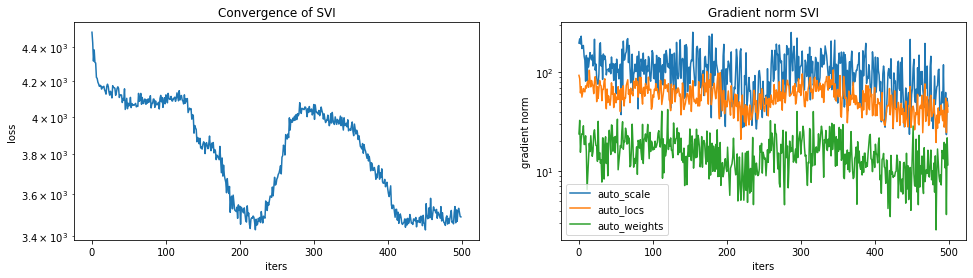

In [34]:
util_gmm.plot_svi_convergence(losses, gradient_norms)

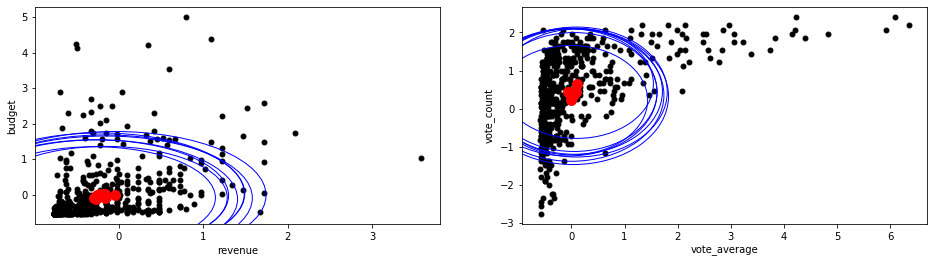

In [35]:
util_gmm.plot_gmm_results(data, locs, scale, K, d)

__Alternative:__ 
* MCMC for full posterior over components. 
* For multivariate covariance matrix, conjugate prior is Inverse-Wishart distribution.
* However, Inverse Wishart is not suitable prior. It is heavy-tailed; which are obstructions to ergodicity requirement for MCMC. 

__Solution:__ 
* LKJCorr prior for full probabilistic covariance. 
* LKFCorr distribution has lighter tails 
* Cholesky factorization for faster computation, $\Sigma= L L^T$


### Experiment 2: NUTS and Normal-LKJCorr Prior

### Model

Given same setup before, define covariance matrix as:
\begin{equation}
    \Sigma = diag(\theta) \Omega diag(\theta)
\end{equation}

$\theta$ scale vector, $\Omega$ correlation matrix:
\begin{align}
    \theta &\sim HalfCauchy(1) \\
    \Omega &\sim LKJCorr(\eta) \\
\end{align}

LKJ correlation distribution:
\begin{equation}
    LKJCorr(\Sigma | \eta) \propto det(\Sigma)^{\eta -1}
\end{equation}

In [36]:
def model(data):
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(K)))
    theta = pyro.sample("theta", dist.HalfCauchy(1*torch.ones(d)).to_event(1))
    eta = torch.ones(1)
    L_omega = pyro.sample("L_omega", dist.LKJCorrCholesky(d, eta))
    L_Omega = torch.mm(torch.diag(theta.sqrt()), L_omega)
    with pyro.plate('components', K):
        mu = pyro.sample('locs', dist.MultivariateNormal(
            torch.zeros(d), 1*torch.eye(d)))
    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample("obs", dist.MultivariateNormal(
            mu[assignment], scale_tril=L_Omega), obs=data)


global_guide = AutoDelta(
    poutine.block(model, expose=['weights', 'locs', 'L_omega']))

### Inference

Run NUTS over 250 samples, draw trace plots of posterior samples and compute Bayes estimate.

In [37]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4)
mcmc = MCMC(kernel, num_samples=250, warmup_steps=50)
mcmc.run(data)
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 2/2 [00:00,  4.22it/s, step size=1.60e-03, acc. prob=0.000]


In [38]:
Sigma_samples = util_gmm.get_Sigma_samples(posterior_samples)
cov = util_gmm.get_bayes_estimate_cov(Sigma_samples, K)
mu = util_gmm.get_bayes_estimate_mu(posterior_samples)
pi = util_gmm.get_bayes_estimate_pi(posterior_samples)

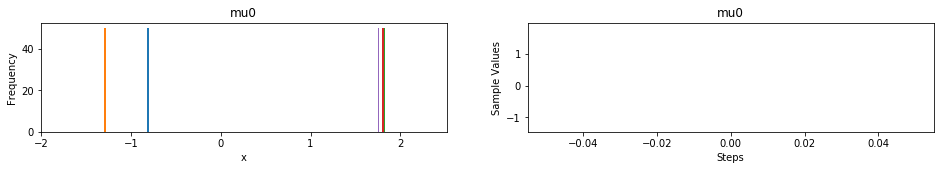

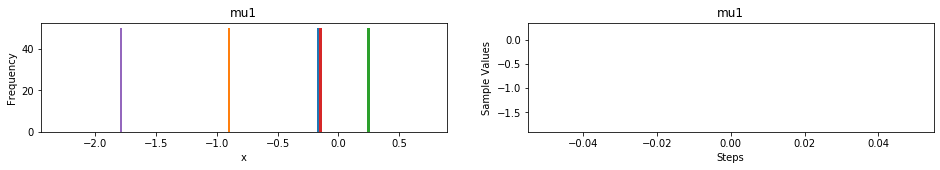

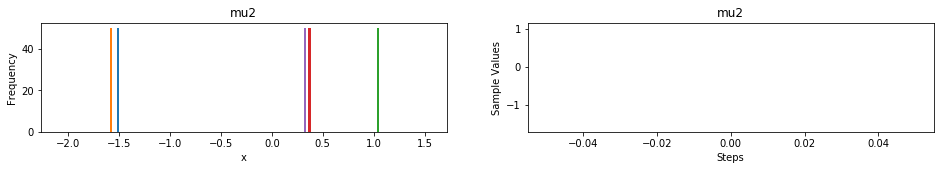

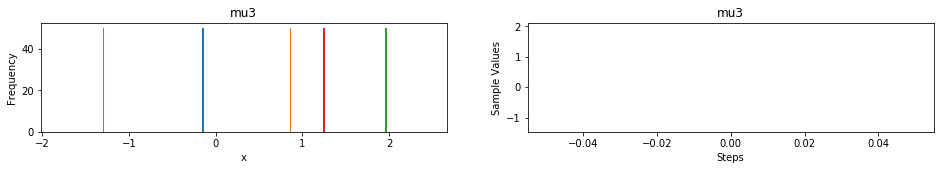

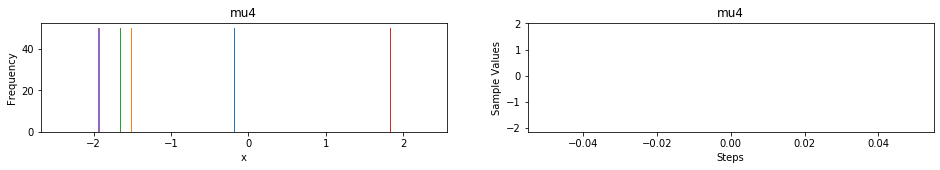

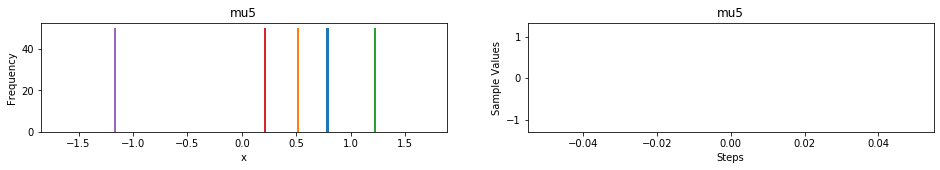

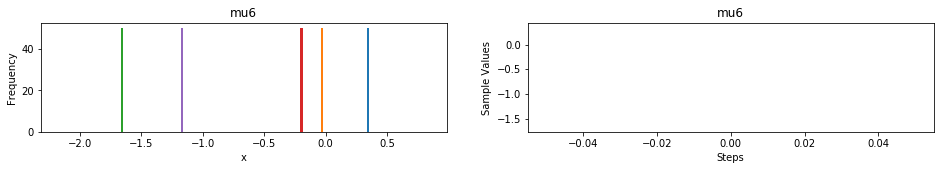

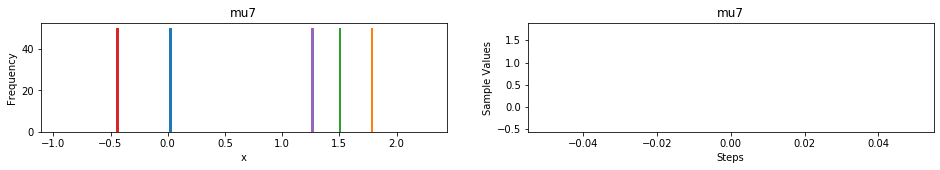

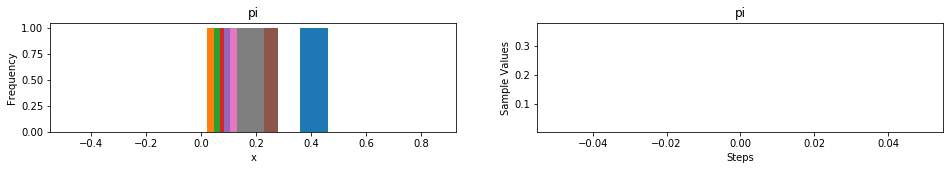

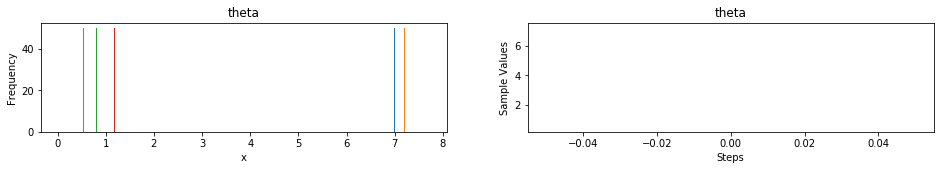

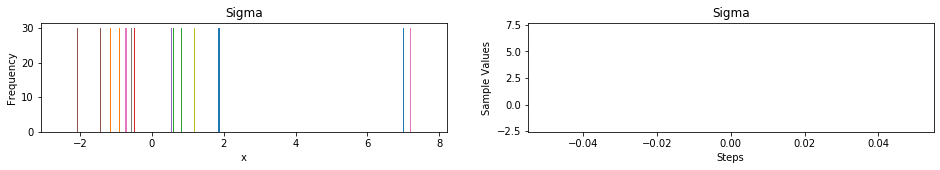

In [39]:
util_gmm.plot_mcmc_mu(posterior_samples, K, d)
util_gmm.plot_mcmc_pi(posterior_samples, K, d)
util_gmm.plot_mcmc_theta(posterior_samples, K, d)
util_gmm.plot_mcmc_Sigma(Sigma_samples, K, d)

### Criticism

__Results:__ 
* Components of $\mu_k, \Sigma_k$ seem to capture general distribution of data well.
* Most of density in GMM is clustered within single component.
* Looking at the assignments, there is no significant pattern (genres/release periods) within each group.

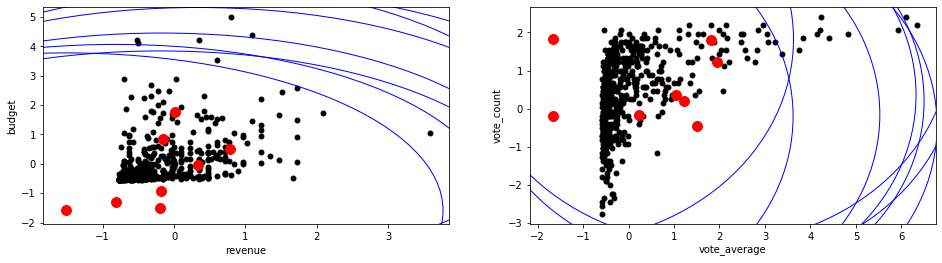

In [40]:
util_gmm.plot_gmm_results(data, mu, cov, K, d)

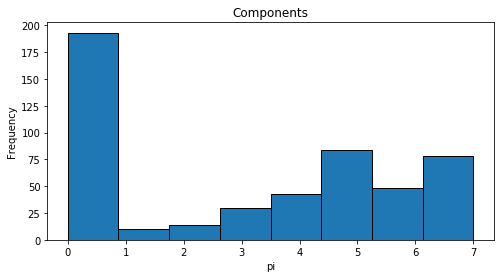

In [41]:
predictive = Predictive(model, posterior_samples)
assignment = predictive.get_samples(data)["assignment"][-1, :]
util_gmm.plot_assignments(assignment, K)

### PPC

Use realized discrepancy $d(x, \theta)$, which is function of both data and hidden variables. Ex. log-likelihood for GMMs:
\begin{align}
    d(x, \theta) 
    &= \sum_{i=1}^{n} \log p(x_i | \theta)
\end{align}

In [42]:
# Compute replicated samples from posterior predictive
data_rep = util_gmm.get_replicated_data(data, mu, cov, pi)

In [43]:
d_obs = util_gmm.compute_log_likelihood(data, mu, cov, pi)
d_rep = util_gmm.compute_log_likelihood(data_rep, mu, cov, pi)
ppc = np.sqrt((d_obs - d_rep)**2)

### POP-PC

In [44]:
d_new = util_gmm.compute_log_likelihood(data_new, mu, cov, pi)
d_rep = util_gmm.compute_log_likelihood(data_rep, mu, cov, pi)
pop_pc = np.sqrt((d_new - d_rep)**2)

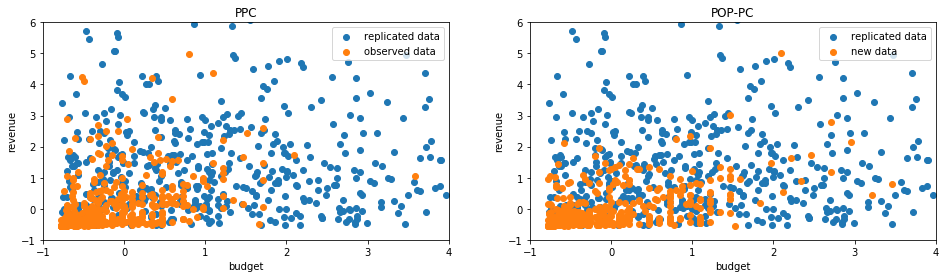

In [45]:
util_gmm.plot_rep_obs_new_data(data, data_rep, data_new)

### Choosing  K using PPC and POP-PC 

Data is collected from repeating experiments above and changing K to observe how PPCs/POP-PCs respond.

__Findings:__ 
* POP-PCs are higher than PPCs which is expected.
* As $K$ increases from 10 onwards, discrepancy of POP-PCs increases while PPCs do not increase as much; PPC/POP-PC scores are optimal between 6-10. 
* *Zig-Zag* pattern s.t. *even* clusters tend to have lower scores; *odd* clusters have higher scores, suggesting that optimal number of clusters is 6, 8, or 10.

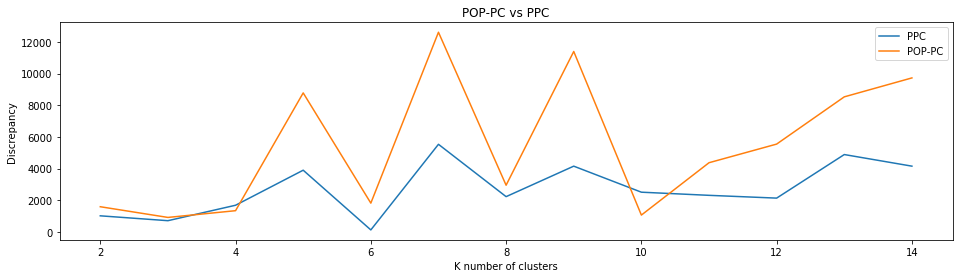

In [46]:
util_gmm.plot_ppc_vs_poppc()